## Analysis and Forecast of US Inflation

**We examine inflation data: CPI and PCE, including the core versions, 
along with the 10-year BEI rate (break-even inflation). 
An unified inflation statistic *m4infl* is defined, 
and we make a univariate forecast using the Holt-Winters 
model with optimized robust parameters.
The stochastic characteristics of *m4infl* are
discussed, including its geometric mean rate.**

The Fed would like the inflation rate for the US economy 
to be around 2%. As of 2018-03-07, our one-year forecast 
is 2.33% -- which calls for moderately tight interest rate policy 
given current inflation levels.

Appendix 2 presents function `foreinfl()` which concisely 
implements the forecasting process derived in this notebook.

Shortcut to the latest version of this notebook: https://git.io/infl

*Dependencies:*

- fecon235 repository, https://github.com/rsvp/fecon235
- FRED, free data service from the Federal Reserve Bank 

*CHANGE LOG*

    2018-03-12  Appendix 2: Add foreinfl() to distill forecasting.
    2018-03-07  Fix #2, update data, optimize Holt-Winters forecast.
                    Drop section on correlation to gold.
    2015-02-02  Code review and revision. Include sample forecast.
    2014-09-02  Introduce new inflation series m4infl. Use getfred().
    2014-08-06  Major revision directly based on refined modules.
    2014-07-25  Expand to include inflation statistics including BEI.
                    Major fix of yi_fred.getdataframe()
    2014-07-24  First version includes module yi_fred converted from fred-plot notebook.

In [1]:
from fecon235.fecon235 import *

In [2]:
#  PREAMBLE-p6.15.1223d :: Settings and system details
from __future__ import absolute_import, print_function, division
system.specs()
pwd = system.getpwd()   # present working directory as variable.
print(" ::  $pwd:", pwd)
#  If a module is modified, automatically reload it:
%load_ext autoreload
%autoreload 2
#       Use 0 to disable this feature.

#  Notebook DISPLAY options:
#      Represent pandas DataFrames as text; not HTML representation:
import pandas as pd
pd.set_option( 'display.notebook_repr_html', False )
from IPython.display import HTML # useful for snippets
#  e.g. HTML('<iframe src=http://en.mobile.wikipedia.org/?useformat=mobile width=700 height=350></iframe>')
from IPython.display import Image 
#  e.g. Image(filename='holt-winters-equations.png', embed=True) # url= also works
from IPython.display import YouTubeVideo
#  e.g. YouTubeVideo('1j_HxD4iLn8', start='43', width=600, height=400)
from IPython.core import page
get_ipython().set_hook('show_in_pager', page.as_hook(page.display_page), 0)
#  Or equivalently in config file: "InteractiveShell.display_page = True", 
#  which will display results in secondary notebook pager frame in a cell.

#  Generate PLOTS inside notebook, "inline" generates static png:
%matplotlib inline   
#          "notebook" argument allows interactive zoom and resize.

 ::  Python 2.7.14
 ::  IPython 5.4.1
 ::  jupyter_core 4.4.0
 ::  notebook 5.4.0
 ::  matplotlib 1.5.1
 ::  numpy 1.14.1
 ::  scipy 1.0.0
 ::  sympy 1.1.1
 ::  pandas 0.22.0
 ::  pandas_datareader 0.6.0
 ::  Repository: fecon235 v5.17.0722 develop
 ::  Timestamp: 2018-03-12T16:18:51Z
 ::  $pwd: /media/yaya/virt18g/virt/dbx/Dropbox/ipy/fecon235/nb


### Retrieving data

Each economic time series has its own *"fredcode"* which is listed 
at the FRED site, see 
[yi_fred module](https://github.com/rsvp/fecon235/blob/master/lib/yi_fred.py) 
for details.

Let's create a dictionary `ts` of time series in pandas DataFrame 
format from our codelists.

In [3]:
print(ml_infl)
print(ml_long)

['CPIAUCSL', 'CPILFESL', 'PCEPI', 'PCEPILFE']
['GS10', 'FII10', 'm4spx']


In [4]:
#  Download updated inflation and bond statistics:
ts = {}
for i in ml_infl + ml_long:
    ts[i] = get(i)

 ::  S&P 500 prepend successfully goes back to 1957.


In [5]:
#  Collection of historical inflation levels:
tsinf = [ ts[i] for i in ml_infl ]

#  Then make a DataFrame consisting of those levels:
inf_levels = paste( tsinf )
#  ... paste() does a side-by-side mash-up
#  of individual time series.

In [6]:
#  Label the column names:
inf_levels.columns = ['CPI', 'CPIc', 'PCE', 'PCEc']

In [7]:
#  Compute year-over-year inflation rates, expressed in percent:
inf = pcent(inf_levels, 12).dropna()
#  since data is monthly ^

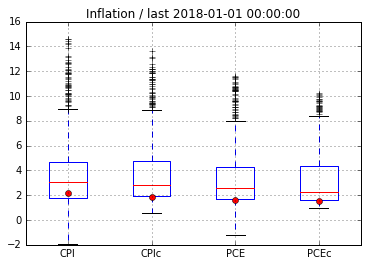

 ::  Finished: boxplot-Inflation.png


In [8]:
boxplot( inf, 'Inflation' )

**The small appended "c" denotes *core* version of headline versions of inflation. 
The red dot represents the most recent data point.**

Our inflation rates go back to **1960-01-01**. 
CPI looks slightly more volatile than PCE versions.

### Re: Consumer Price Index and Personal Consumption Expenditures

> *"Two different price indexes are popular for measuring inflation: the consumer price index (CPI) from the Bureau of Labor Statistics and the personal consumption expenditures price index (PCE) from the Bureau of Economic Analysis. [A]n accurate measure of inflation is important for both the U.S. federal government and the Federal Reserve's **Federal Open Market Committee** (FOMC), but they focus on different measures. For example, the federal government uses the CPI to make inflation adjustments to certain kinds of benefits, such as Social Security. In contrast, the **FOMC focuses on PCE inflation in its quarterly economic projections and also states its longer-run inflation goal in terms of headline PCE**. The FOMC focused on CPI inflation prior to 2000 but, after extensive analysis, changed to PCE inflation for three main reasons: The expenditure weights in the PCE can change as people substitute away from some goods and services toward others, the PCE includes more comprehensive coverage of goods and services, and historical PCE data can be revised (more than for seasonal factors only)."* --James Bullard, president of the Federal Reserve Bank of St. Louis. 

In [9]:
stats(inf)

              CPI        CPIc         PCE        PCEc
count  697.000000  697.000000  697.000000  697.000000
mean     3.775549    3.757137    3.313203    3.263301
std      2.860426    2.590589    2.455981    2.170832
min     -1.958761    0.602718   -1.183584    0.947246
25%      1.796020    1.963907    1.655400    1.610806
50%      3.038138    2.803738    2.545597    2.271314
75%      4.647160    4.732510    4.242936    4.358226
max     14.592275   13.604488   11.577525   10.233897

 ::  Index on min:
CPI    2009-07-01
CPIc   2010-10-01
PCE    2009-07-01
PCEc   2010-12-01
dtype: datetime64[ns]

 ::  Index on max:
CPI    1980-03-01
CPIc   1980-06-01
PCE    1974-10-01
PCEc   1975-02-01
dtype: datetime64[ns]

 ::  Head:
                 CPI      CPIc       PCE      PCEc
T                                                 
1960-01-01  1.240951  2.006689  1.670171  2.028755
1960-02-01  1.413793  2.341137  1.686311  2.140951
1960-03-01  1.518813  2.000000  1.679398  2.047995
 ::  Tail:
        

### Unified inflation

The numbers confirm the core version is less volatile than headline inflation. 
Moreover, headline versions are most correlated. 
Note how the dates of the minimum and maximum values do not coincide.

So what is the appropriate inflation rate among the contenders? 
We shall take the *average of the contenders* to arrive at **unified inflation**.

In [10]:
#  Compute unified inflation:
inf_av = todf(( inf['CPI'] + inf['CPIc'] + inf['PCE'] + inf['PCEc'] ) / 4 )

In [11]:
stats( inf_av )

                Y
count  697.000000
mean     3.527297
std      2.466253
min     -0.160953
25%      1.720500
50%      2.687746
75%      4.481560
max     12.016273

 ::  Index on min:
Y   2009-07-01
dtype: datetime64[ns]

 ::  Index on max:
Y   1980-03-01
dtype: datetime64[ns]

 ::  Head:
                   Y
T                   
1960-01-01  1.736641
1960-02-01  1.895548
1960-03-01  1.811551
 ::  Tail:
                   Y
T                   
2017-11-01  1.790604
2017-12-01  1.776136
2018-01-01  1.787264

 ::  Correlation matrix:
     Y
Y  1.0


Speaking of unified inflation rates, we can now say 
that the maximum occurred in March 1980 at 12%, 
and that minimum occurred in July 2009 during the 
Great Recession at -0.16% (slight deflation).

In [12]:
#  The shortest of our time series under consideration, m4tips10, 
#  starts at 2003-01-01, so let
start = '2003-01-01'

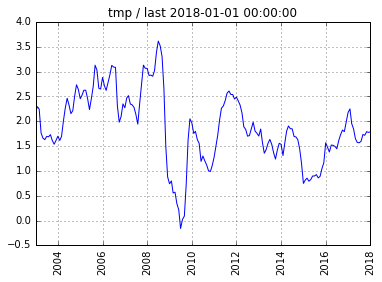

In [13]:
#  Plot unified inflation, given start:
plot( inf_av[start:] )

We can see the dramatic drop in the unified inflation rate 
during the Great Recession.

## Break-even inflation 

BEI is computed using only data from the bond market. 
The key BEI uses 10-year US government bonds, 
taking the difference in rates between the 
usual on-the-run bond and the TIPS issue. 
TIPS is an abbreviation for "Treasury Inflation Protected Security."

TIPS allow us to observe *real* interest rates
being traded in the market. 
(Notebook https://git.io/gold makes a conjecture 
that real gold prices is a stationary time-series 
bound by real interest rates.) 

In [14]:
bei = todf( ts[m4bond10] - ts[m4tips10] )

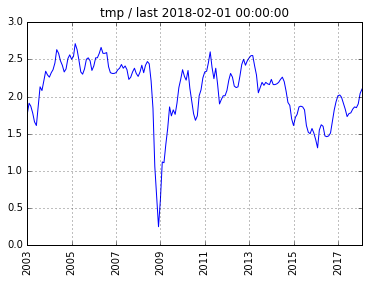

In [15]:
#  Plot Break-even inflation rate
plot( bei[start:] )

In [16]:
tail(bei)

               Y
T               
2017-08-01  1.78
2017-09-01  1.83
2017-10-01  1.86
2017-11-01  1.85
2017-12-01  1.90
2018-01-01  2.04
2018-02-01  2.10

Studies comparing forward-looking BEI and realized inflation generally show 
*BEI overestimates realized inflation*. 

What is the correlation between BEI and average inflation? 
Not much. BEI seems to lead unified inflation, cf. circa 2009. 
Also, BEI appears more stable relative to unified inflation.

It is worth emphasizing that 
**unified inflation is a "rear view"** while ***BEI is "forward looking."*** 
Real money bets are made on the spread of the latter. 

#### Present: unified inflation and BEI

Let us mix the rear and forward views equally at arrive at a **"present view"**, 
`bei_inf_av`.

In [17]:
bei_inf_av = todf((bei + inf_av) / 2) 

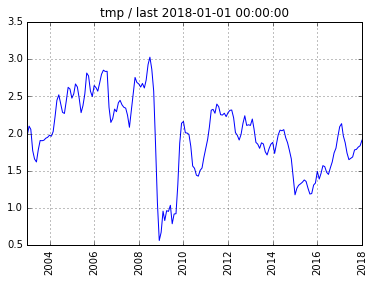

In [18]:
#  Plot present view:
plot( bei_inf_av[start:] )

In [19]:
#  Probably the best accessment of current inflation:
tail(bei_inf_av)

                   Y
T                   
2017-07-01  1.668481
2017-08-01  1.687450
2017-09-01  1.782154
2017-10-01  1.788856
2017-11-01  1.820302
2017-12-01  1.838068
2018-01-01  1.913632

Our present inflation measure consisting of 1 part each of 
CPI, CPI core, PCE, PCE core -- plus 4 parts of BEI. 
It does have strong correlation with the Fed's favored inflation measure, 
see Appendix 1.

## Unified inflation *level*

To readily access our findings above in other studies, 
we developed the synthetic pre-fabricated **m4infl** series. 
Each measure of inflation *levels* is first rescaled such that 
the most recent point is equal to 1. 
This eliminates the base year problem and the 
arbitrarily set level of 100 somewhere in time. 
Then we can take the average among inflation levels which 
will be by mathematical construction, *equally weighted*. 
The levels originate from fredcodes: 
`['CPIAUCSL', 'CPILFESL', 'PCEPI', 'PCEPILFE']`.

As a very convenient by-product, the recipricol of m4infl 
yields *multiplicative factors useful for deflating prices*, see **m4defl**.

(API note: The average between backward and forward-looking inflation *rates* 
is codified as **m4inflbei**.)

In [20]:
infl = get(m4infl)

#  m4infl represents unified inflation level, synthesized
#  from four different US government time-series.

In [21]:
#  Latest levels of unified inflation:
tail(infl)

                   Y
T                   
2017-07-01  0.985627
2017-08-01  0.987997
2017-09-01  0.990815
2017-10-01  0.992491
2017-11-01  0.994326
2017-12-01  0.996198
2018-01-01  1.000000

In [22]:
#  From the level, we compute annual rates:
inflrate = pcent(infl, 12)

In [23]:
#  VERIFY if our two methods agree, by linear regression:
stat2( inf_av['Y'], inflrate['Y'] )
#  (Think of this as an unit test, visible in a notebook.)
#  'Y' is the default column label.

 ::  FIRST variable:
count    697.000000
mean       3.527297
std        2.466253
min       -0.160953
25%        1.720500
50%        2.687746
75%        4.481560
max       12.016273
Name: Y, dtype: float64

 ::  SECOND variable:
count    697.000000
mean       3.509197
std        2.443296
min       -0.183227
25%        1.720457
50%        2.669016
75%        4.461897
max       11.867394
Name: Y, dtype: float64

 ::  CORRELATION
0.9999565267346865
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.993e+06
Date:                Mon, 12 Mar 2018   Prob (F-statistic):               0.00
Time:                        09:19:31   Log-Likelihood:                 1640.9
No. Observations:                 697   AIC:                            -3278

The result shows perfect correlation since 1960 (full dataset), 
thus our synthetic series **m4infl** works as intended.

### Geometric mean rate of unified inflation

The level form of unified inflation allows us to 
directly use the tools developed for financial assets.

In [24]:
gemrat(infl[start:], yearly=12)

[1.8681557525558556,
 1.8694514743803674,
 0.5137664910401363,
 10.311330360312478,
 12,
 180]

The geometric mean rate of unified inflation is 1.87% 
since `start`, the volatility is 0.51%, 
thus a 50 basis point move in a year would not be surprising. 
The most interesting statistic reveals that *inflation is leptokurtotic*.

The arithmetic mean rate sought by the Federal Reserve 
is currently 2%, so the economy in this aspect is 
within policy expectations.

## Holt-Winters forecast for inflation

For predicting inflation, it is preferable to use levels, rather than rates, 
as primary form of time-series due to linearity considerations 
(see plot in the next cell).

Forecasting will be covered in detail in another notebook. 
But here we demonstrate the **Holt-Winters model**.

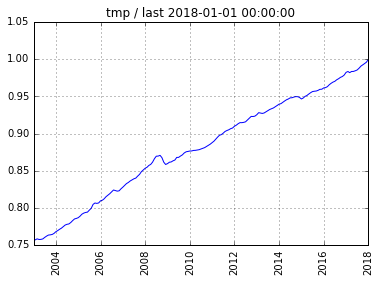

In [25]:
#  Visualize unified inflation levels:
plot(infl[start:])

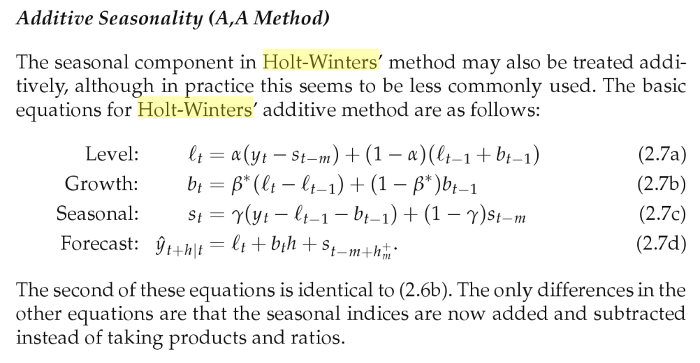

In [26]:
Image(filename='holt-winters-equations.png', embed=True)

We can safely ignore the seasonal portion of the model 
since the relevant data has been deseasonalized at the upstream source.

Two important parameters, $\alpha$ and $\beta$, must estimated. 
We developed a robust L1 estimation technique which 
minimizes one-step ahead forecast errors, 
conditional on specific data. See 
[ys_opt_holt module](https://github.com/rsvp/fecon235/blob/master/lib/ys_opt_holt.py) 
for details.

In [27]:
#  This optimization procedure may be computationally intense, 
#  depending on data size and the number of grids.

ab = optimize_holt( infl, grids=50 )

ab

 !.  WARNING: ipykernel_launcher.py Optimizing Holt-Winters alphabetaloss may take TIME!


[1.0, 0.3673, 0.0307, 0.00030739713869681884]

The first two elements in the `ab` list are $\alpha$ and $\beta$ respectively. 
The third element gives the median absolute loss as percent for an 
one-step ahead forecast given those parameters. 
The fourth element is the median absolute loss 
(due to our L1 loss function for robust optimization).

The median absolute loss is 0.00031 
which gives us confidence that the model has performed well.

Using the estimated parameters, we can now proceed to 
generate our 12-step ahead forecast. See 
[yi_timeseries module](https://github.com/rsvp/fecon235/blob/master/lib/yi_timeseries.py) 
for details.

In [28]:
holtdf = holt( infl, alpha=ab[0], beta=ab[1] )
holtforecast( holtdf, h=12 )

    Forecast
0   1.000000
1   1.002566
2   1.005132
3   1.007698
4   1.010264
5   1.012829
6   1.015395
7   1.017961
8   1.020527
9   1.023093
10  1.025659
11  1.028225
12  1.030791

Since the most current level of unified inflation 
is 1.00 by construction, it is easy to discern that: 
***the 12-months ahead forecast implies an annualized inflation rate of 3.08%.***

From the standpoint of Fed policy, this upward acceleration 
of the inflation rate is a bit alarming 
since the move is greater than two standard deviations. 
It would favor more increased hikes in the Fed funds rate.

## Forecasting summary

Forecasting is an art. 
A pearl of wisdom is to combine orthogonal methods 
to arrive at excellence.

Here are three non-related ways which characterized inflation:

- BEI, Break-even Inflation: a long-term forecast implied by the bond market
- Geometric mean rate: internal growth rate of a stochastic trend
- Holt-Winters model: projection obtained by robust prediction error minimization

The respective results are simply averaged...

In [29]:
( 2.04 + 1.87 + 3.08 ) / 3

2.33

There are many sorts of inflation measures, 
but we devised a mathematically unified version. 
The bond market has its own version, 
so for the **one-year ahead forecast**, 
all in all, we shall settle for:
**2.33%**.

---

## Appendix 1:  Overall Correlations

In [30]:
#  Conversions to dataframe with label before paste:
dfa = todf( inf_av, 'Iav')
dfb = todf( bei, 'BEI' )
dfc = todf( bei_inf_av, 'BEI_Iav')

In [31]:
#  Mother of all annualized inflation rates:
infall = paste( [inf, dfa, dfb, dfc] )

In [32]:
#  CORRELATION matrix going back to 2003-01-01 (start of BEI):
cormatrix(infall)

              CPI      CPIc       PCE      PCEc       Iav       BEI   BEI_Iav
CPI      1.000000  0.396734  0.991881  0.727324  0.973333  0.596251  0.930337
CPIc     0.396734  1.000000  0.380431  0.812429  0.578716  0.157139  0.473951
PCE      0.991881  0.380431  1.000000  0.759407  0.974031  0.624653  0.942230
PCEc     0.727324  0.812429  0.759407  1.000000  0.862696  0.493943  0.810729
Iav      0.973333  0.578716  0.974031  0.862696  1.000000  0.587671  0.945828
BEI      0.596251  0.157139  0.624653  0.493943  0.587671  1.000000  0.818525
BEI_Iav  0.930337  0.473951  0.942230  0.810729  0.945828  0.818525  1.000000

CPI and PCE are tightly correlated, as are CPIc and PCEc. 
Surprisingly, CPI and CPIc are only moderately correlated, only 40%. 
Recall that headline inflation includes food and energy, 
whereas core inflation excludes those components.

The market traded BEI break-even inflation is modestly correlated 
with government-released statistics of inflation.

#### Most recent computed data

Given in annualized percentage form:

In [33]:
#  Inflation RATES
tail(infall, n=12)

                 CPI      CPIc       PCE      PCEc       Iav   BEI   BEI_Iav
T                                                                           
2017-02-01  2.765943  2.197494  2.176721  1.861760  2.250479  2.02  2.135240
2017-03-01  2.392636  1.991838  1.825633  1.610806  1.955228  1.99  1.972614
2017-04-01  2.195585  1.881641  1.732041  1.577605  1.846718  1.91  1.878359
2017-05-01  1.867699  1.740672  1.514083  1.475945  1.649600  1.83  1.739800
2017-06-01  1.648658  1.719232  1.416262  1.504955  1.572277  1.73  1.651138
2017-07-01  1.740413  1.710167  1.404816  1.412455  1.566963  1.77  1.668481
2017-08-01  1.950792  1.694847  1.435583  1.298376  1.594899  1.78  1.687450
2017-09-01  2.230133  1.699529  1.655954  1.351617  1.734308  1.83  1.782154
2017-10-01  2.034204  1.774644  1.593239  1.468763  1.717713  1.86  1.788856
2017-11-01  2.201742  1.712094  1.742919  1.505658  1.790604  1.85  1.820302
2017-12-01  2.111342  1.760828  1.705745  1.526629  1.776136  1.90  1.838068

## Appendix 2: Forecasting process as a function

We can think of this notebook as the documentation 
which encapsulates its findings and process 
into a single function: `foreinfl()`.

In [34]:
#  Query into its details:
foreinfl??

Signature: foreinfl(n=120, alpha=1.0, beta=0.3673)
Source:   
def foreinfl( n=120, alpha=1.0, beta=0.3673 ):
    '''Forecast Unified Inflation 1-year ahead per fred-inflation.ipynb.'''
    #  Holt-Winters parameters alpha and beta are optimized
    #  from the 1960-2018 dataset, consisting of 697 monthly points.
    #  Each "way" is an orthogonal method, to be averaged as way[0].
    way = [-9, -9, -9, -9, -9]
    inflall = get( m4infl )  # synthetic Unified Inflation, monthly.
    infl = tail(inflall, n)
    #                    ^Default n=120 months, i.e. last 10 years.
    way[1] = str(infl.index[-1]).replace(" 00:00:00", "")
    #                ^Most recent month for CPI, CPIc, PCE, PCEc data.
    gm = gemrat( infl, yearly=12 )
    way[2] = gm[0]  #  Geometric Mean Rate over n months.
    hw = foreholt( infl, 12, alpha, beta )  # Holt-Winters model.
    way[3] = (tailvalue(hw) - 1) * 100   # Convert forecasted level to rate.
    bond10 = get(m4bond10)
    tips10 = get(m4tips10)
  

In [35]:
#  See it in action:
foreinfl()

[2.252780993104452,
 '2018-01-01',
 1.5792838373316131,
 3.0790591419817437,
 2.0999999999999996]

There are slight variations from the notebook derivation.

- Instead of `start` we use a rolling window of `n` monthly datapoints.
- By default, `n` is set to 120, i.e. the last ten years.
- Given new data, we do not re-optimize the Holt-Winters parameters, since that would be computationally expensive. The default values for alpha and beta are battle-tested using data dating back to 1960.
- Bond market data does not suffer from release lag, unlike inflation statistics, so the most *current* BEI is used in the `foreinfl()` function.

To obtain an inflation forecast in practice, 
executing a single Python function is far more convenient 
than re-running a Jupyter notebook. 
The list output also gives a summary from the orthogonal methods 
which were utilized.